In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd drive/My\ Drive/Projects/TimeSeriesForecasting

/content/drive/My Drive/Projects/TimeSeriesForecasting


In [0]:
import os
import json
import numpy as np
import pandas as po
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [0]:
from keras import optimizers
from keras.models import Model, Sequential
from keras.layers import Conv1D, Dense, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [0]:
os.makedirs('model_checkpoints', exist_ok=True)
os.makedirs('plots', exist_ok=True)

In [0]:
df = po.read_csv('data/2017_energy_5min_noTransform.csv')

In [0]:
scaler = MinMaxScaler()
df['W'] = scaler.fit_transform(df)

In [0]:
class Args:
  def __init__(self):
    self.val_start = 12*24*250
    self.test_start = 12*24*300
    self.train_seq_len = 12*24*7
    self.val_seq_len = 12*24
    
    self.num_channels = 100
    self.kernel_size = 12
    self.batch_size = 512
    self.num_epochs = 25
    
    self.save_folder = 'Dilated_CNN'

In [0]:
args = Args()

In [0]:
os.makedirs('plots/' + args.save_folder, exist_ok=True)
os.makedirs('model_checkpoints/' + args.save_folder, exist_ok=True)

In [0]:
train_df = df[: args.val_start]
val_df = df[args.val_start: args.test_start]
test_df = df[args.test_start:]

In [0]:
#scaler.inverse_transform(train)

In [0]:
def make_windows(data, train_seq_len = args.train_seq_len, val_seq_len = args.val_seq_len):
    X = []
    y = []

    for i in tqdm(range(train_seq_len, len(data) - val_seq_len + 1)):    
        X.append(data.values[i - train_seq_len: i].T.tolist())
        y.append(data.values[i: i + val_seq_len].T.tolist())

    X = np.array(X).squeeze().reshape(-1, train_seq_len, 1)
    y = np.array(y).squeeze()

    return X, y

In [0]:
X_train, y_train = make_windows(train_df)

100%|██████████| 69697/69697 [00:11<00:00, 5820.43it/s]


In [0]:
X_val, y_val = make_windows(val_df)

100%|██████████| 12097/12097 [00:01<00:00, 7948.88it/s]


In [0]:
model = Sequential()
model.add(Conv1D(args.num_channels, kernel_size= args.kernel_size, padding='causal', strides=1, activation='relu', dilation_rate=1, input_shape=(args.train_seq_len, 1)))
model.add(Conv1D(args.num_channels, kernel_size= args.kernel_size, padding='causal', strides=1, activation='relu', dilation_rate=2))
model.add(Conv1D(args.num_channels, kernel_size= args.kernel_size, padding='causal', strides=1, activation='relu', dilation_rate=4))
model.add(Conv1D(args.num_channels, kernel_size= args.kernel_size, padding='causal', strides=1, activation='relu', dilation_rate=8))
model.add(Conv1D(args.num_channels, kernel_size= args.kernel_size, padding='causal', strides=1, activation='relu', dilation_rate=16))
model.add(Conv1D(args.num_channels, kernel_size= args.kernel_size, padding='causal', strides=1, activation='relu', dilation_rate=32))
model.add(Conv1D(args.num_channels, kernel_size= args.kernel_size, padding='causal', strides=1, activation='relu', dilation_rate=64))
model.add(Conv1D(args.num_channels, kernel_size= args.kernel_size, padding='causal', strides=1, activation='relu', dilation_rate=128))
model.add(Flatten())
model.add(Dense(args.val_seq_len, activation='linear'))

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 2016, 100)         1300      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2016, 100)         120100    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2016, 100)         120100    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 2016, 100)         120100    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 2016, 100)         120100    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 2016, 100)         120100    
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 2016, 100)        

In [0]:
sgd = optimizers.SGD(lr=0.1, decay=1e-2, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd)

NameError: ignored

In [0]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2)
best_val = ModelCheckpoint('model_checkpoints/' + args.save_folder + '/model_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)

NameError: ignored

In [0]:
history = model.fit(X_train, y_train, batch_size = args.batch_size, epochs = args.num_epochs, validation_data = (X_val, y_val), callbacks=[earlystop, best_val], verbose=1)

Train on 69697 samples, validate on 12097 samples
Epoch 1/25
69697/69697 [==============================] - 663s 10ms/step - loss: 0.0221 - val_loss: 0.0080
Epoch 2/25
69697/69697 [==============================] - 636s 9ms/step - loss: 0.0086 - val_loss: 0.0071
Epoch 3/25
69697/69697 [==============================] - 636s 9ms/step - loss: 0.0082 - val_loss: 0.0068
Epoch 4/25
69697/69697 [==============================] - 636s 9ms/step - loss: 0.0081 - val_loss: 0.0068
Epoch 5/25
69697/69697 [==============================] - 636s 9ms/step - loss: 0.0080 - val_loss: 0.0067
Epoch 6/25
69697/69697 [==============================] - 636s 9ms/step - loss: 0.0079 - val_loss: 0.0066
Epoch 7/25
69697/69697 [==============================] - 643s 9ms/step - loss: 0.0078 - val_loss: 0.0066
Epoch 8/25
69697/69697 [==============================] - 644s 9ms/step - loss: 0.0077 - val_loss: 0.0065
Epoch 9/25
69697/69697 [==============================] - 643s 9ms/step - loss: 0.0077 - val_loss: 0.

In [0]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights('model_checkpoints/' + args.save_folder + '/model_{:02d}.h5'.format(best_epoch))
best_epoch

25

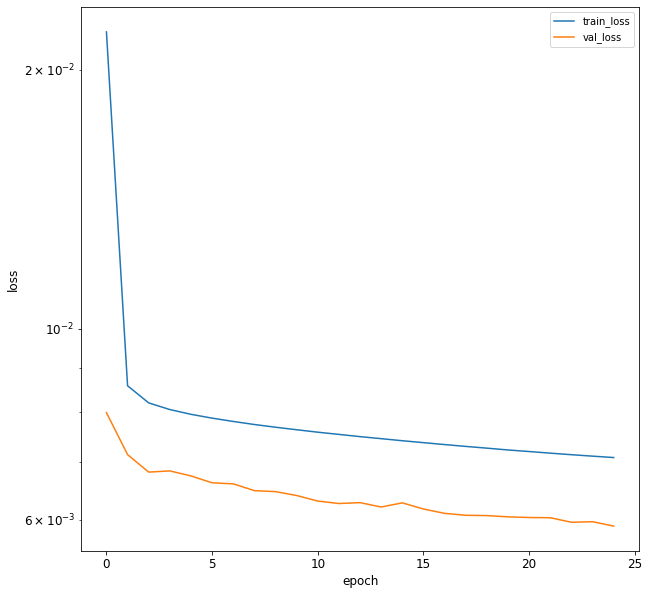

In [0]:
plot_df = po.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.savefig('plots/'  + args.save_folder + '/train_val_loss.png')
plt.show()

In [0]:
X_test, y_test = make_windows(test_df)

100%|██████████| 12097/12097 [00:01<00:00, 7805.46it/s]


In [0]:
y_pred = model.predict(X_test)

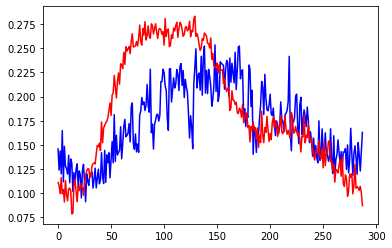

In [0]:
plt.plot(y_test[0], color = 'blue')
plt.plot(y_pred[0], color = 'red')
plt.savefig('plots/' + args.save_folder + '/test_weekend_pred.png')

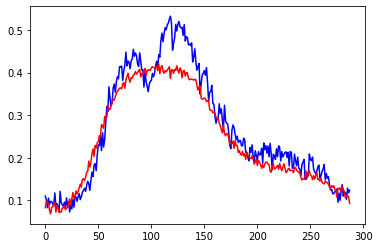

In [0]:
plt.plot(y_test[12*24*2], color = 'blue')
plt.plot(y_pred[12*24*2], color = 'red')
plt.savefig('plots/'  + args.save_folder + '/test_weekday_pred.png')

In [0]:
if not os.path.exists('results.csv'):
  results = po.DataFrame(columns = ['model', 'MAE', 'MSE', 'R2'])  
else:
  results = po.read_csv('results.csv')

In [0]:
errors = {'model': args.save_folder,
          'MAE': mean_absolute_error(y_true=y_test, y_pred=y_pred),
          'MSE': mean_squared_error(y_true=y_test, y_pred=y_pred),
          'R2': r2_score(y_true=y_test, y_pred=y_pred)
          }
errors = po.Series(errors)
results = results.append(errors, ignore_index=True)

In [0]:
results

,model,MAE,MSE,R2
0,Dilated_CNN,0.042400,0.003150,0.679306
1,vanillaLSTM,0.134216,0.022371,-1.277546
2,CNN_LSTM,0.059652,0.005216,0.469051
3,bidirectionalLSTM,0.126920,0.020101,-1.046449
4,CNN_LSTM,0.066086,0.006133,0.375636
5,convLSTM,0.040161,0.002803,0.714712
6,Dilated_CNN,0.037945,0.002629,0.732376


In [0]:
results.to_csv('results.csv', index=False)

In [0]:
with open('model_checkpoints/' + args.save_folder + '/params.json', 'w') as f:
  f.write(json.dumps(args.__dict__))
f.close()